In [3]:
import os
import cv2
import torch
import numpy as np
import supervision as sv

from groundingdino.util.inference import Model
from groundingdino.util import box_ops
from segment_anything import sam_model_registry, SamPredictor


In [4]:
def get_device():
    """
    Get the device available for torch.

    Returns
    -------
    device : torch.device
        The available device.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

In [5]:
def load_models(sam_checkpoint_path, model_type, grounding_dino_config_path, grounding_dino_weight_path, device):
    """
    Load the models.

    Parameters
    ----------
    sam_checkpoint_path : str
        The path to the checkpoint file of the SAM model.
    model_type : str
        The type of the SAM model to be loaded.
    grounding_dino_config_path : str
        The path to the config file of the Grounding DINO model.
    grounding_dino_weight_path : str
        The path to the weight file of the Grounding DINO model.
    device : torch.device
        The device to load the models on.

    Returns
    -------
    sam_predictor : SamPredictor
        The SAM predictor.
    grounding_dino_model : Model
        The Grounding DINO model.
    """
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint_path).to(device=device)
    sam_predictor = SamPredictor(sam)

    grounding_dino_model = Model(
        model_config_path=grounding_dino_config_path, 
        model_checkpoint_path=grounding_dino_weight_path, 
        device=device
    )

    return sam_predictor, grounding_dino_model

In [6]:
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    """
    Segment the detections using SAM predictor.

    Parameters
    ----------
    sam_predictor : SamPredictor
        The SAM predictor.
    image : np.ndarray
        The image containing the detections.
    xyxy : np.ndarray
        The bounding boxes of the detections.

    Returns
    -------
    result_masks : np.ndarray
        The segmented masks of the detections.
    """
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [7]:
def predict_and_annotate(image_path, text_prompt, box_threshold, text_threshold, sam_predictor, grounding_dino_model):
    """
    Load an image, predict and annotate the detections.

    Parameters
    ----------
    image_path : str
        The path to the image file.
    text_prompt : str
        The text prompt for the prediction.
    box_threshold : float
        The box threshold for the prediction.
    text_threshold : float
        The text threshold for the prediction.
    sam_predictor : SamPredictor
        The SAM predictor.
    grounding_dino_model : Model
        The Grounding DINO model.

    Returns
    -------
    annotated_image : np.ndarray
        Image with bounding box and segmentation annotations.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detections, phrases = grounding_dino_model.predict_with_caption(
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=image, # cv2.cvtColor(image, cv2.COLOR_BGR2RGB), hold on is gounding dino getting the wrong colors?
        xyxy=detections.xyxy
    )
    
    box_annotator = sv.BoxAnnotator()
    mask_annotator = sv.MaskAnnotator()
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=phrases)

    return annotated_image


In [8]:
def load_image(image_path):
    """
    Load an image from the specified file.

    Parameters
    ----------
    image_path : str
        The path to the image file.

    Returns
    -------
    image : np.ndarray
        Loaded image.
    """
    return cv2.imread(image_path)


def get_detections(image, text_prompt, box_threshold, text_threshold, grounding_dino_model):
    """
    Predict and get the detections.

    Parameters
    ----------
    image : np.ndarray
        Image for prediction.
    text_prompt : str
        The text prompt for the prediction.
    box_threshold : float
        The box threshold for the prediction.
    text_threshold : float
        The text threshold for the prediction.
    grounding_dino_model : Model
        The Grounding DINO model.

    Returns
    -------
    detections : Detections
        Detections from the model.
    phrases : list
        Detected phrases from the model.
    """
    return grounding_dino_model.predict_with_caption(
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )


def segment_detections(sam_predictor, image, detections):
    """
    Segment the detections.

    Parameters
    ----------
    sam_predictor : SamPredictor
        The SAM predictor.
    image : np.ndarray
        Image for prediction.
    detections : Detections
        Detections for segmentation.

    Returns
    -------
    detections : Detections
        Detections with updated masks.
    """
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=image,
        xyxy=detections.xyxy
    )
    return detections


def predict_and_generate_masks(image_path, text_prompt, box_threshold, text_threshold, sam_predictor, grounding_dino_model):
    """
    Load an image, predict and generate the mask images.

    Parameters
    ----------
    image_path : str
        The path to the image file.
    text_prompt : str
        The text prompt for the prediction.
    box_threshold : float
        The box threshold for the prediction.
    text_threshold : float
        The text threshold for the prediction.
    sam_predictor : SamPredictor
        The SAM predictor.
    grounding_dino_model : Model
        The Grounding DINO model.

    Returns
    -------
    mask_image : np.ndarray
        Image with mask annotations.
    """
    image = load_image(image_path)
    detections, _ = get_detections(image, text_prompt, box_threshold, text_threshold, grounding_dino_model)
    detections = segment_detections(sam_predictor, image, detections)

    return detections.mask


In [9]:
def find_images(directory, extension):
    """
    Returns the abs path to all files with a specified extension in a parent directory.

    Parameters
    ----------
    directory : str
        The parent directory to search for the files.
    extension : str
        The extension of the files to be found.

    Returns
    -------
    images : list
        The list of absolute paths to the found files.
    """
    images = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_path = os.path.join(root, file)
                images.append(file_path)
    return images

In [10]:
device = get_device()

sam_checkpoint_path = "../../models/sam_models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

grounding_dino_config_path = "/scratch/gpfs/eh0560/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
grounding_dino_weight_path = "/scratch/gpfs/eh0560/imagedeskewing/models/grounding_dino_models/groundingdino_swint_ogc.pth"

sam_predictor, grounding_dino_model = load_models(
    sam_checkpoint_path, 
    model_type, 
    grounding_dino_config_path, 
    grounding_dino_weight_path, 
    device
)

/home/eh0560/.conda/envs/torch_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
tif_image_paths = find_images("/scratch/gpfs/RUSTOW/htr_deskewing_image_dataset/NEED_DESKEWING", ".tif")
image_path = tif_image_paths[34]
text_prompt = "old brown paper"
box_threshold = 0.50
text_threshold = 0.25

/home/eh0560/.conda/envs/torch_env/lib/python3.9/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/eh0560/.conda/envs/torch_env/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


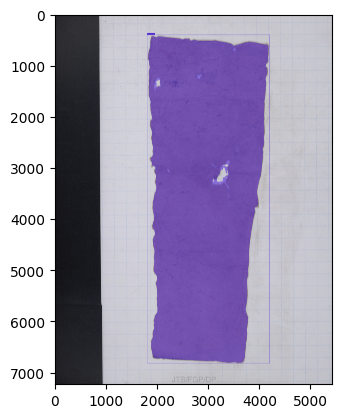

In [12]:
annotated_image = predict_and_annotate(image_path, text_prompt, box_threshold, text_threshold, sam_predictor, grounding_dino_model)
import matplotlib.pyplot as plt
plt.imshow(annotated_image)

In [13]:
masks = predict_and_generate_masks(image_path, text_prompt, box_threshold, text_threshold, sam_predictor, grounding_dino_model)

In [14]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
mask = (masks[0] * 255).astype(np.uint8)
masked_image = gray & mask

In [15]:
from deskew import determine_skew
from skimage.transform import rotate

angle = determine_skew(masked_image)
print(f"{angle:.2f}")
rotated = rotate(image, angle, resize=True)

3.00


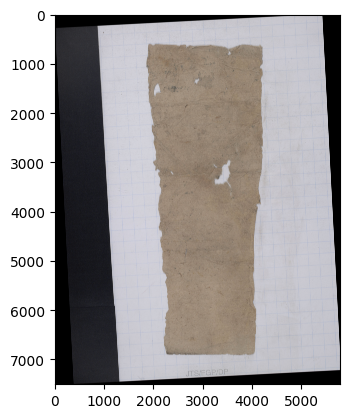

In [16]:
import matplotlib.pyplot as plt
plt.imshow(rotated)